<a href="https://colab.research.google.com/github/XULEARNING/Projects-Done/blob/main/Smart%20City%20Projects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BA865 Final Project
##*Keshuo Liu, Qianru Ai, Zheming Xu*

keshuol@bu.edu, qianruai@bu.edu, xzm21@bu.edu

## Problem Statement
According to the Wikipedia definition, “a smart city is a technologically modern urban area that uses different types of electronic methods, voice activation methods, and sensors to collect specific data.” The construction and governance of smart cities integrate technologies in information and communication technology (ICT) and Internet of Things (IoT) that connect physical devices, including sensors and surveillance, to improve the efficiency of city governance, regarding public transportation, utility services, parking and vehicles, public art, etc. The City of Boston, an active responder to the “smart city” project, has been taking action by using data to decide changes on road planning, traffic regulation enforcement, public education to be made. The City of Boston also released “Go Boston 2030”, a vision and action plan on transportation future. The main goal of this plan is to expand access, improve safety, and ensure liability. </br></br>

Our group plans to build deep learning algorithms about crowd counting because we think it can be a fundamental algorithm for broad application. For example, crowd counting can detect the number of waiting crowds at bus/train stops and intersections, number of passengers, number of crowds in offices/institutions and public facilities. (Covid Social Distance)<br></br>

Crowd counting is to count people in different images. It is mainly used in real life for automated public monitoring such as surveillance and traffic control, which is a pretty important part of a smart city. Under the current pandemic situation, crowd counting is a more heating topic because it could be used to monitor the risk of disease transmission. Different from object detection, crowd counting is more complex since each person has different features, and clothing, posture, and crowding levels may obscure the body and face to varying degrees. We hope to complete our first exploration of smart cities through our research on crowd counting.

## Dataset
**Train + Validation:**</br>
Original Source: http://personal.ie.cuhk.edu.hk/~ccloy/downloads_mall_dataset.html  </br>
This dataset is composed by 2000 RGB images of frames in a video (as inputs) and the object counting on every frame, this is the number of pedestrians (object) in the image. The images are 480x640 pixels at 3 channels of the same spot recorded by a webcam in a mall but it has a different number of people on every frame. The label of this dataset is the ‘count’ of people in each frame which is an existing feature in the dataset.</br>
**Test (34): Public Transportation**</br>
We took 34 pictures of the crowd waiting for the green line or traffic lights for testing. The label of this dataset is also ‘count’.</br>

**Important Note: Because our group project has used callbacks, and recall the model for the test dataset evaluation, the models are stored in Google Drive. The code for saving the model to the content directory has been commented.**</br>

# DataPrep

import

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.applications import vgg16, inception_v3, resnet50
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from PIL import Image
import sklearn
import glob

Mounted at /content/gdrive/


In [ ]:
# !rm -rf ba865data

In [ ]:
!git clone https://github.com/aliceai0810/ba865data.git

Cloning into 'ba865data'...
remote: Enumerating objects: 2097, done.
remote: Counting objects: 100% (2097/2097), done.
remote: Compressing objects: 100% (2087/2087), done.
remote: Total 2097 (delta 19), reused 2083 (delta 8), pack-reused 0
Receiving objects: 100% (2097/2097), 94.43 MiB | 16.20 MiB/s, done.
Resolving deltas: 100% (19/19), done.


load Numerics



In [ ]:
df = pd.read_csv("/content/ba865data/labels.csv")
df=df.rename({'count':'crowd_num'},axis=1)
labels = df['crowd_num']
print(labels.describe())

count    2000.000000
mean       31.157500
std         6.945417
min        13.000000
25%        26.000000
50%        31.000000
75%        36.000000
max        53.000000
Name: crowd_num, dtype: float64


In [ ]:
df['image_name'] = df['id'].map('seq_{:06d}.jpg'.format)

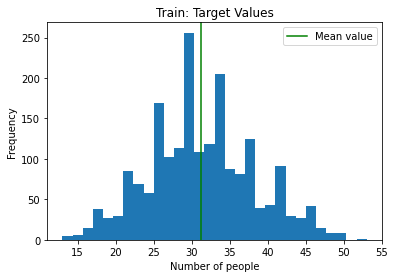

In [ ]:
plt.hist(df['crowd_num'],bins=30)
plt.axvline(df['crowd_num'].mean(),label='Mean value',color='green')
plt.legend()
plt.xlabel('Number of people')
plt.ylabel('Frequency')
plt.title('Train: Target Values')
plt.show()

Load image 

In [ ]:
image_size = (256,256)
def read_images():
    image_list = []
    for file in glob.glob(f"/content/ba865data/frames/*"):
        im=Image.open(file)
        im=im.resize(size=image_size)
        image_list.append(np.divide(np.array(im),255))
    return np.stack(image_list)

image = read_images()

In [ ]:
image.shape

(2000, 256, 256, 3)

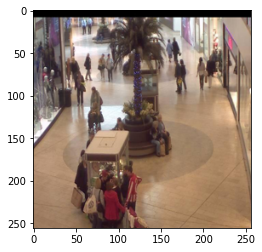

In [ ]:
plt.imshow(image[1600]);

# Define Model

For model layers, we first use data augmentation with horizonal flip, rotation, zoom, rescaling. Then we use Conv2D with residual block to run for padding and strides. During our exploration, when use the combination of Batch Normalization and Activation layers with 2D convolution layer for the residual blocks, the model may not converge because of its complexity, therefore, we combine the activation in the Conv2D in the end. All the activation functions are ReLU, because all the data in labels and the pixel values are larger than 0. We also use dropout to prevent over-estimate. For the following layers after the GlobalMaxPooling2D, we set Dense layers with depth from 128 to 8 before the output layer,instead of 128 to 2, to make it converge. Because we are moddeling the crowd number, we use mean_absolute_error as the loss funtion as it is more robust to outliers, and use Adam as the optimizer since it is more efficient and requires less RAM. 


In [ ]:
def build_model(rotation=0.1,zoom=0.2,kernal_size=3,filters=16,strides=2,dropout=0.5,optimizer="Adam",):
  input_image = layers.Input(shape=(image.shape[1],image.shape[2],image.shape[3]), name="Images")
  x = layers.RandomFlip("horizontal")(input_image)
  x = layers.RandomRotation(rotation)(x)
  x = layers.RandomZoom(zoom)(x)
  #x = layers.Rescaling(1./255)(x)
  x = layers.Conv2D(filters=filters,kernel_size=kernal_size,use_bias=False)(x)
  def residual_block(x,filters,pooling=False):
    residual=x
    # x = layers.BatchNormalization()(x)
    # x = layers.Activation("relu")(x)
    x = layers.Conv2D(filters,kernal_size, padding="same", use_bias=False,activation='relu')(x)

    # x = layers.BatchNormalization()(x)
    # x = layers.Activation("relu")(x)
    x = layers.Conv2D(filters,kernal_size, padding="same", use_bias=False,activation='relu')(x)

    if pooling:
      x = layers.MaxPooling2D(kernal_size, strides=strides, padding="same")(x)
      residual = layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False)(residual)
    elif filters != residual.shape[-1]:
      residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x
  x=residual_block(x,filters=filters,pooling=True)
  x=residual_block(x,filters=filters*2,pooling=True)
  x=residual_block(x,filters=filters*4,pooling=False)
  x = layers.GlobalMaxPooling2D()(x)
  x = layers.Dropout(dropout)(x)

  n_layers = int(np.log(filters*4)/np.log(2))
  for i in reversed(range(3,n_layers)):
    x=layers.Dense(2**i,activation="relu")(x)

  final_output=layers.Dense(1,activation="relu",name="final_output")(x)
  model=keras.Model(name="Crowd",inputs=input_image,outputs=final_output)
  
  model.compile(loss="mean_absolute_error",optimizer=optimizer,metrics=['mae'])

  return model

# Hyper-parameters

We've tested parameters including kernal_size, strides, units, batch_size, epochs. The best parameters are as following:


*   kernal_size = 3
*   strides = 3
*   units = 32
*   batch_size = 20
*   epochs = 30



In [ ]:
try:
    from scikeras.wrappers import KerasRegressor                     
except ImportError:
    !pip install scikeras
    from scikeras.wrappers import KerasRegressor
    

In [ ]:
regf = KerasRegressor(model=build_model, loss="mean_absolute_error", optimizer="Adam", verbose=0,filters=16,strides=2,kernal_size=3,batch_size=10,epochs=20)


from sklearn.model_selection import GridSearchCV
params = {
    "kernal_size":[3,5],
    "strides":[2,3],
    "filters": [16,32],
    "batch_size": [10,20],
    "epochs": [20,30]
}
grid = GridSearchCV(regf, params, scoring='neg_mean_absolute_error',verbose=11,cv=5)
grid.fit(image, labels)
print(f"Best Score  : {grid.best_score_}")
print(f"Best Params : {grid.best_params_}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5; 1/32] START batch_size=10, epochs=20, filters=16, kernal_size=3, strides=2
[CV 1/5; 1/32] END batch_size=10, epochs=20, filters=16, kernal_size=3, strides=2;, score=-9.551 total time= 1.6min
[CV 2/5; 1/32] START batch_size=10, epochs=20, filters=16, kernal_size=3, strides=2
[CV 2/5; 1/32] END batch_size=10, epochs=20, filters=16, kernal_size=3, strides=2;, score=-7.134 total time= 1.4min
[CV 3/5; 1/32] START batch_size=10, epochs=20, filters=16, kernal_size=3, strides=2
[CV 3/5; 1/32] END batch_size=10, epochs=20, filters=16, kernal_size=3, strides=2;, score=-8.029 total time= 1.4min
[CV 4/5; 1/32] START batch_size=10, epochs=20, filters=16, kernal_size=3, strides=2
[CV 4/5; 1/32] END batch_size=10, epochs=20, filters=16, kernal_size=3, strides=2;, score=-8.964 total time= 1.4min
[CV 5/5; 1/32] START batch_size=10, epochs=20, filters=16, kernal_size=3, strides=2
[CV 5/5; 1/32] END batch_size=10, epochs=20, filters=1

# Fit & Validate

By choosing the best performance parameters, we then use those parameters to check the validation MAE by epochs.

In [ ]:
def build_model_self(rotation=0.1,zoom=0.2,kernal_size=3,filters=32,strides=3,dropout=0.5,optimizer="Adam",):
  input_image = layers.Input(shape=(image.shape[1],image.shape[2],image.shape[3]), name="Images")
  x = layers.RandomFlip("horizontal")(input_image)
  x = layers.RandomRotation(rotation)(x)
  x = layers.RandomZoom(zoom)(x)
  x = layers.Rescaling(1./255)(x)
  x = layers.Conv2D(filters=filters,kernel_size=kernal_size,use_bias=False)(x)
  def residual_block(x,filters,pooling=False):
    residual=x
    # x = layers.BatchNormalization()(x)
    # x = layers.Activation("relu")(x)
    x = layers.Conv2D(filters,kernal_size, padding="same", use_bias=False,activation='relu')(x)

    # x = layers.BatchNormalization()(x)
    # x = layers.Activation("relu")(x)
    x = layers.Conv2D(filters,kernal_size, padding="same", use_bias=False,activation='relu')(x)

    if pooling:
      x = layers.MaxPooling2D(kernal_size, strides=strides, padding="same")(x)
      residual = layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False)(residual)
    elif filters != residual.shape[-1]:
      residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x
  x=residual_block(x,filters=filters,pooling=True)
  x=residual_block(x,filters=filters*2,pooling=True)
  x=residual_block(x,filters=filters*4,pooling=False)
  x = layers.GlobalMaxPooling2D()(x)
  x = layers.Dropout(dropout)(x)

  n_layers = int(np.log(filters*4)/np.log(2))
  for i in reversed(range(3,n_layers)):
    x=layers.Dense(2**i,activation="relu")(x)

  final_output=layers.Dense(1,activation="relu",name="final_output")(x)
  model=keras.Model(name="Crowd",inputs=input_image,outputs=final_output)
  
  model.compile(loss="mean_absolute_error",optimizer=optimizer,metrics=['mae'])

  return model

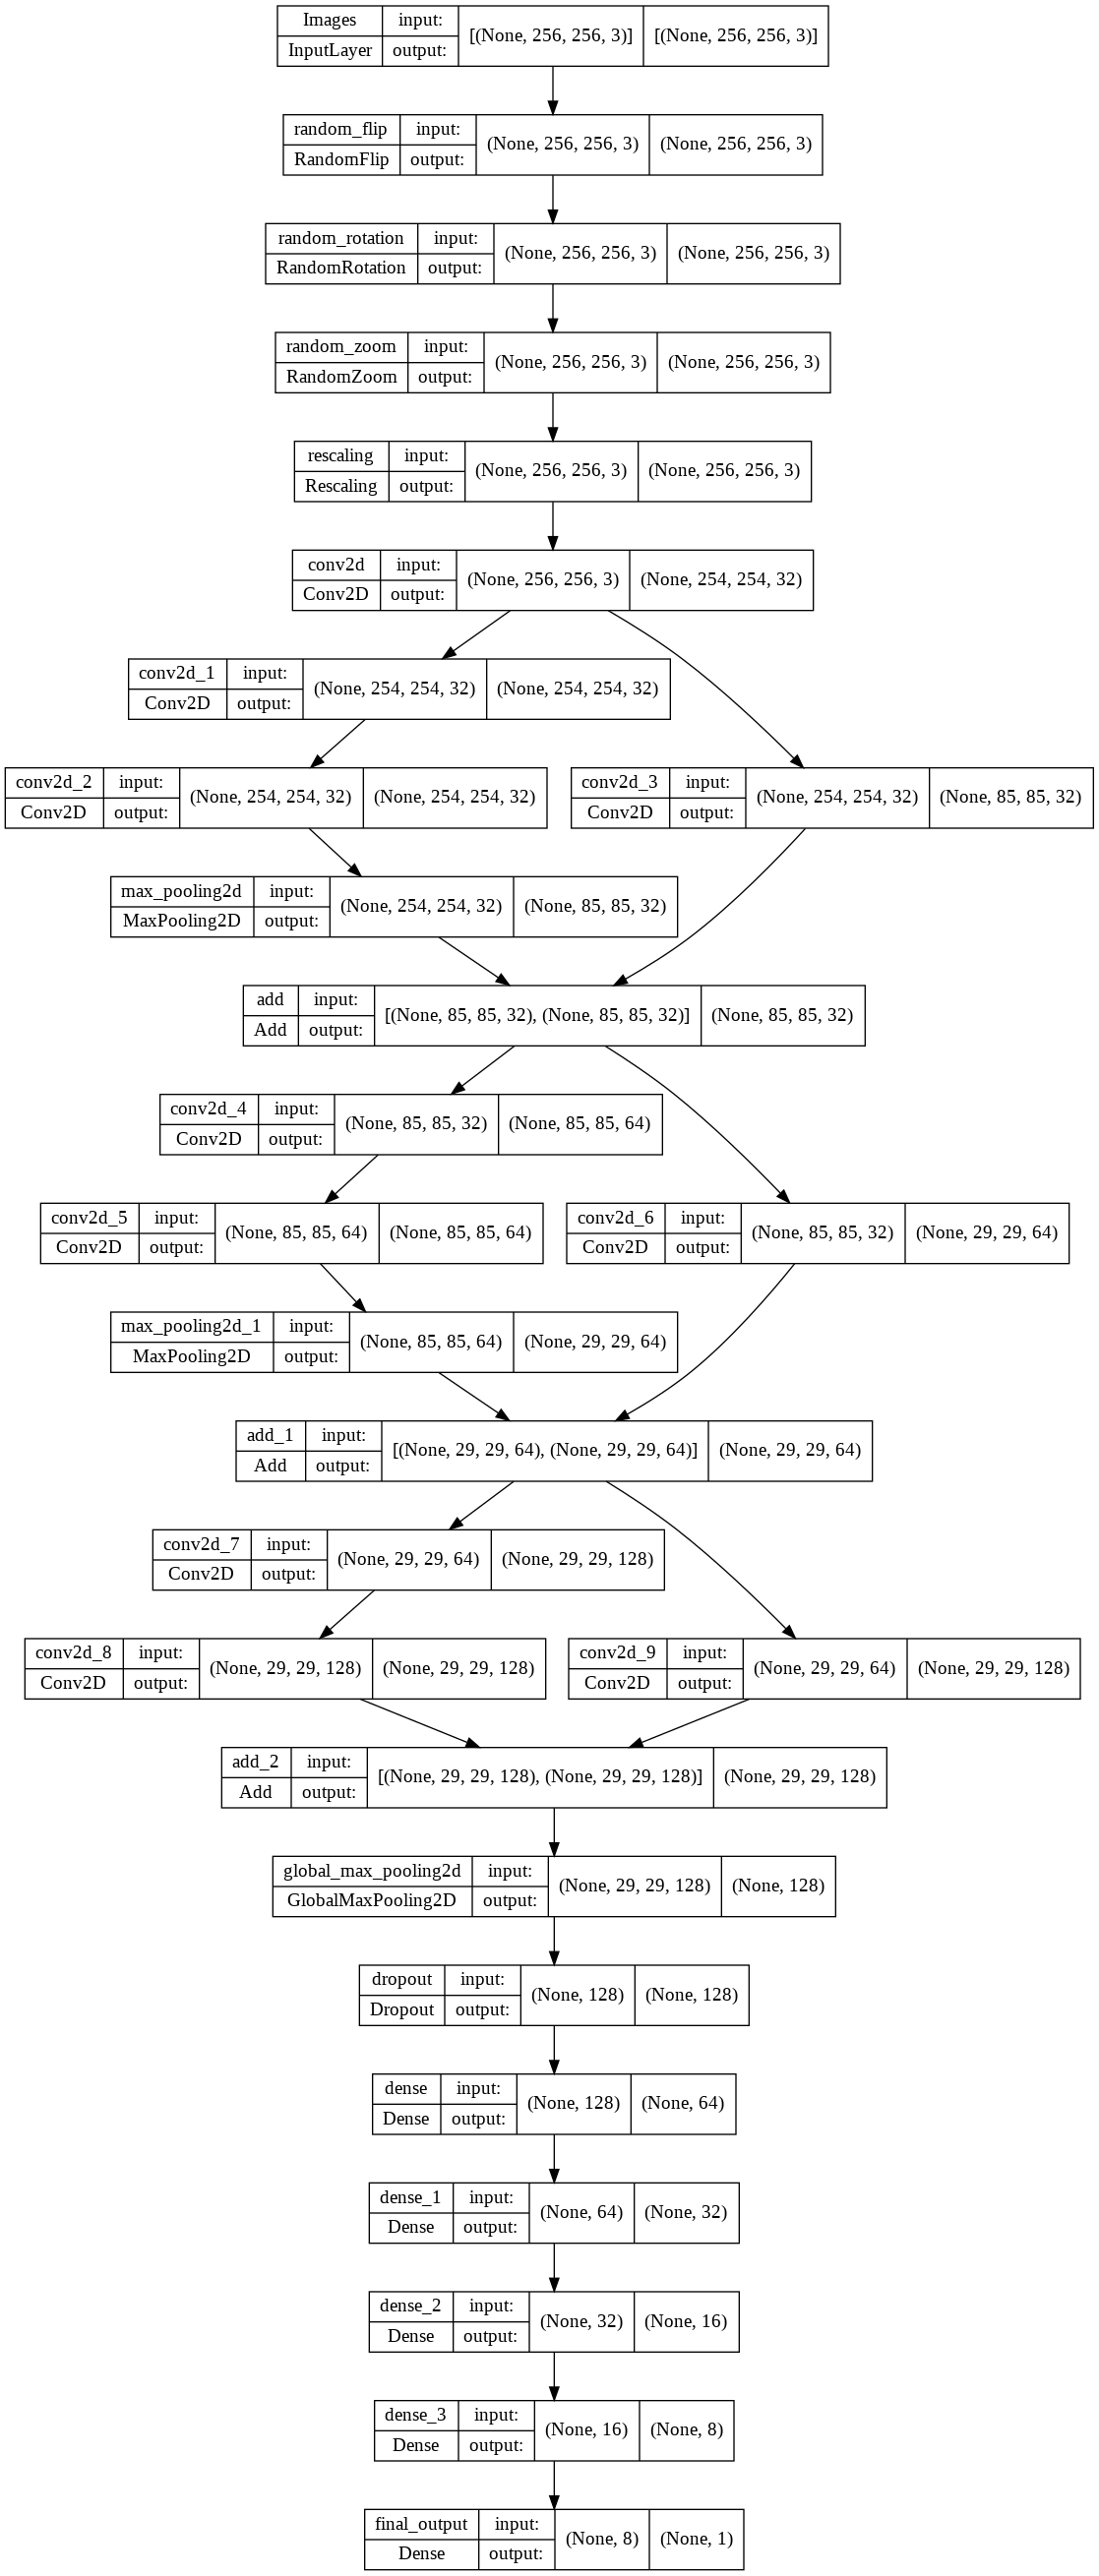

In [ ]:
model = build_model_self()
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
folds = 5
num_val_samples = len(image)//5
num_epochs = 30
batch_size = 20
all_train_mae_histories1, all_val_mae_histories1 = [],[]

callbacks = [
        keras.callbacks.ModelCheckpoint(
        # filepath="/content/self_trained.keras",
        filepath="/content/gdrive/Shareddrives/BA865/self_trained.keras",
        save_best_only=True,
        monitor="val_loss")]

for i in range(folds):

    print("Processing fold #:",i+1)
    
    val_image = image[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = labels[i * num_val_samples: (i + 1) * num_val_samples]
  
    train_image = np.concatenate([image[:i * num_val_samples], image[(i + 1) * num_val_samples:]], axis=0)
    train_targets = np.concatenate([labels[:i * num_val_samples],labels[(i + 1) * num_val_samples:]],axis=0)
    
    model1 = build_model_self()

    history1 = model1.fit(train_image, train_targets,
                        validation_data=(val_image, val_targets),
                        epochs=num_epochs, batch_size=batch_size,callbacks=callbacks)
    
    train_mae_history1 = history1.history['mae']
    val_mae_history1 = history1.history['val_mae']

    all_train_mae_histories1.append(train_mae_history1)
    all_val_mae_histories1.append(val_mae_history1)

average_train_mae_history1 = [np.mean([x[i] for x in all_train_mae_histories1]) for i in range(num_epochs)]
average_val_mae_history1 = [np.mean([x[i] for x in all_val_mae_histories1]) for i in range(num_epochs)]

Processing fold #: 1
Epoch 1/30
80/80 [==============================] - 19s 118ms/step - loss: 12.9682 - mae: 12.9682 - val_loss: 5.8638 - val_mae: 5.8638
Epoch 2/30
80/80 [==============================] - 8s 104ms/step - loss: 6.9310 - mae: 6.9310 - val_loss: 6.9968 - val_mae: 6.9968
Epoch 3/30
80/80 [==============================] - 9s 111ms/step - loss: 6.8402 - mae: 6.8402 - val_loss: 5.4818 - val_mae: 5.4818
Epoch 4/30
80/80 [==============================] - 8s 106ms/step - loss: 7.3282 - mae: 7.3282 - val_loss: 6.6734 - val_mae: 6.6734
Epoch 5/30
80/80 [==============================] - 8s 106ms/step - loss: 6.7786 - mae: 6.7786 - val_loss: 6.3276 - val_mae: 6.3276
Epoch 6/30
80/80 [==============================] - 9s 107ms/step - loss: 6.9502 - mae: 6.9502 - val_loss: 7.7848 - val_mae: 7.7848
Epoch 7/30
80/80 [==============================] - 9s 108ms/step - loss: 6.9401 - mae: 6.9401 - val_loss: 12.2993 - val_mae: 12.2993
Epoch 8/30
80/80 [==============================] 

6.24


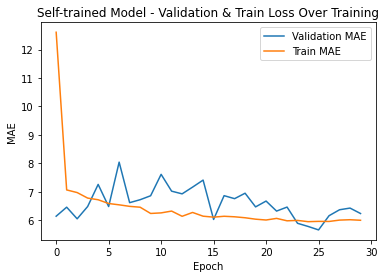

In [ ]:
avg_val_mae_self = round(average_val_mae_history1[-1],3)
print(avg_val_mae_self)

plt.plot(average_val_mae_history1,label='Validation MAE')
plt.plot(average_train_mae_history1,label='Train MAE')
plt.legend()
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.title('Self-trained Model - Validation & Train Loss Over Training')
plt.show()

# Explore Pre-trained model

## Img2vec: Image Vector embeddings

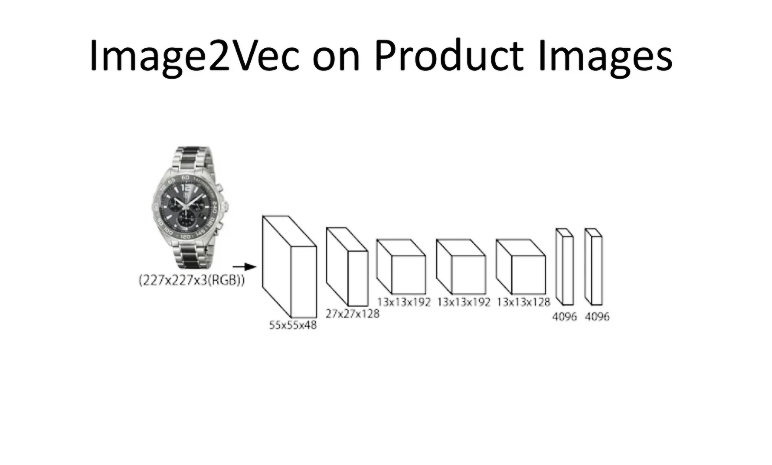

This is a model that could extract vector embeddings from any image. 

In [ ]:
# try img2vec
!pip install img2vec_pytorch
from img2vec_pytorch import Img2Vec

In [ ]:
# Initialize Img2Vec with GPU
img2vec = Img2Vec(cuda=True)

def read_img_pre():
  image_list = []
  for file in glob.glob(f"/content/ba865data/frames/*"):
    im=Image.open(file)
    vec = img2vec.get_vec(im)
    image_list.append(np.array(vec))
  return np.array(image_list)

image2 = read_img_pre()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
image2.shape

(2000, 512)

With img2vec, we transformed images into 512 length vectors with default Resnet-18 model in the package. Then we fit the pre-processed data into common layer model.

In [ ]:
def build_model_preTrain_Image2vec():
  # image input
    input = layers.Input(shape=image2.shape[1], name="Image")
    x = layers.Dense(64,activation="relu")(input)
    x = layers.Dense(32,activation="relu")(x)
    x = layers.Dense(16,activation="relu")(x)
    x = layers.Dense(8,activation="relu")(x)
    output = layers.Dense(1)(x)

    model_preTrain = keras.Model(inputs=input,outputs=output)

    model_preTrain.compile(loss="mae",optimizer="Adam",metrics=['mae'])

    return model_preTrain

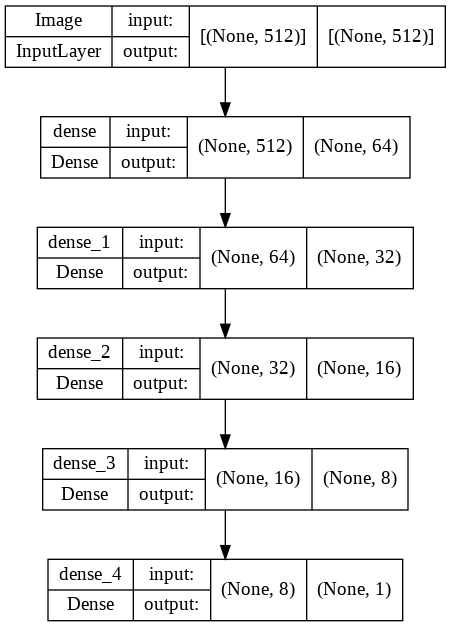

In [ ]:
model2 = build_model_preTrain_Image2vec()
keras.utils.plot_model(model2, show_shapes=True)

In [ ]:
# Fit & validation
folds = 5
num_val_samples = len(image2)//5
num_epochs = 20
batch_size = 30
all_train_mae_histories2, all_val_mae_histories2 = [],[]

callbacks = [
        keras.callbacks.ModelCheckpoint(
        filepath="/content/gdrive/Shareddrives/BA865/pre_trained_Image2vec.keras",
        # filepath="/content/pre_trained_Image2vec.keras",
        save_best_only=True,
        monitor="val_loss")]
        
for i in range(folds):

    print("Processing fold #:",i+1)
    
    val_image = image2[i * num_val_samples: (i + 1) * num_val_samples]

    val_targets = labels[i * num_val_samples: (i + 1) * num_val_samples]
  
    train_image = np.concatenate([image2[:i * num_val_samples], image2[(i + 1) * num_val_samples:]], axis=0)

    train_targets = np.concatenate([labels[:i * num_val_samples],labels[(i + 1) * num_val_samples:]],axis=0)
    
    model2 = build_model_preTrain_Image2vec()

    history2 = model2.fit(train_image, train_targets,
                        validation_data=(val_image, val_targets),
                        epochs=num_epochs, batch_size=batch_size,callbacks=callbacks)
    
    train_mae_history2 = history2.history['mae']
    val_mae_history2 = history2.history['val_mae']

    all_train_mae_histories2.append(train_mae_history2)
    all_val_mae_histories2.append(val_mae_history2)

average_train_mae_history2 = [np.mean([x[i] for x in all_train_mae_histories2]) for i in range(num_epochs)]
average_val_mae_history2 = [np.mean([x[i] for x in all_val_mae_histories2]) for i in range(num_epochs)]

Processing fold #: 1
Epoch 1/20
54/54 [==============================] - 4s 26ms/step - loss: 14.2291 - mae: 14.2291 - val_loss: 5.6966 - val_mae: 5.6966
Epoch 2/20
54/54 [==============================] - 0s 4ms/step - loss: 5.7058 - mae: 5.7058 - val_loss: 5.5569 - val_mae: 5.5569
Epoch 3/20
54/54 [==============================] - 0s 3ms/step - loss: 5.6672 - mae: 5.6672 - val_loss: 5.4946 - val_mae: 5.4946
Epoch 4/20
54/54 [==============================] - 0s 3ms/step - loss: 5.7517 - mae: 5.7517 - val_loss: 5.5957 - val_mae: 5.5957
Epoch 5/20
54/54 [==============================] - 0s 4ms/step - loss: 5.6539 - mae: 5.6539 - val_loss: 5.4913 - val_mae: 5.4913
Epoch 6/20
54/54 [==============================] - 0s 3ms/step - loss: 5.6701 - mae: 5.6701 - val_loss: 5.7015 - val_mae: 5.7015
Epoch 7/20
54/54 [==============================] - 0s 3ms/step - loss: 5.6005 - mae: 5.6005 - val_loss: 5.6429 - val_mae: 5.6429
Epoch 8/20
54/54 [==============================] - 0s 4ms/step - 

5.936


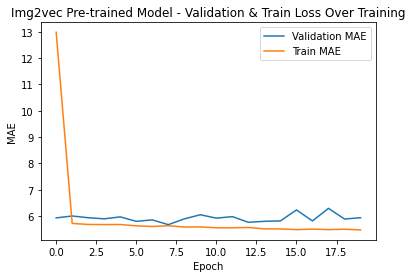

In [ ]:
avg_val_mae_Img2vec = round(average_val_mae_history2[-1],3)
print(avg_val_mae_Img2vec)

plt.plot(average_val_mae_history2,label='Validation MAE')
plt.plot(average_train_mae_history2,label='Train MAE')
plt.legend()
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.title('Img2vec Pre-trained Model - Validation & Train Loss Over Training')
plt.show()

## MCNN: Multi-Column Convolutional Neural Network

The MCNN model is originated from a paper called Single-Image Crowd Counting via Multi-Column Convolutional Neural Network (http://people.eecs.berkeley.edu/~yima/psfile/Single-Image-Crowd-Counting.pdf). The main idea is that it cut an image to pieces with three different sizes in parallel and merge the layers after processing them seperately to a density map. The benefit of using MCNN model is that it can better processing both dense and sparse crowd as it tries different cutting sizes.

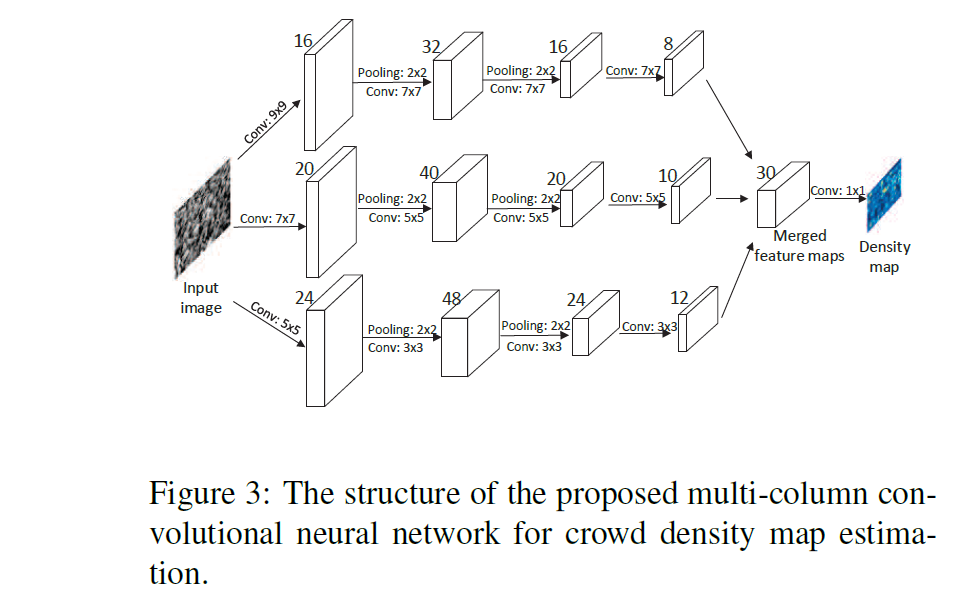

To apply the MCNN model, we first resize our images into 256x256 and normalize them. After that, loading the pre-trained parameters. The parameters we used is based on Shanghai street images from https://github.com/svishwa/crowdcount-mcnn (under name Shanghai Tech B: https://www.dropbox.com/s/kqqkl0exfshsw8v/mcnn_shtechB_110.h5?dl=0). The Because the original model is for testing data with loss layer, so we only used the parts before that. Also, the pre-trained model is based on the torch package, we used this package to pre-process image first, then use the more familiar keras to continue our own application. The original dimensions for the branches is just one channel. But the only trained parameter resource passes three channels into each branch. The owner of this Github repository states that the result is the same comparing to the method from the original article. In the end, we use this one get the transformed data. Because it’s in 30 channels, we added an additional GlobalMaxPooling layer to come up with one dimensional data for the later dense layers.


In [ ]:
import os
import sys
sys.path.append("/content/ba865data/MCNN")
# sys.path.append("/content/gdrive/Shareddrives/BA865/MCNN")
from crowd_count import CrowdCounter
from MCNN import MCNN
import network
import torch
import PIL.Image as Image
from torchvision import datasets, transforms

In [ ]:

transform = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [ ]:
net = CrowdCounter()
trained_model = os.path.join('/content/ba865data/MCNN/mcnn_shtechB_110.h5')
# trained_model = os.path.join('/content/gdrive/Shareddrives/BA865/MCNN/mcnn_shtechB_110.h5')
network.load_net(trained_model, net)
MCNN=net.cuda()

In [ ]:
MCNN

CrowdCounter(
  (DME): MCNN(
    (branch1): Sequential(
      (0): Conv2d(
        (conv): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (relu): ReLU(inplace=True)
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): Conv2d(
        (conv): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (relu): ReLU(inplace=True)
      )
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(
        (conv): Conv2d(32, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (relu): ReLU(inplace=True)
      )
      (5): Conv2d(
        (conv): Conv2d(16, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (relu): ReLU(inplace=True)
      )
    )
    (branch2): Sequential(
      (0): Conv2d(
        (conv): Conv2d(3, 20, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (relu): ReLU(inplace=True)
      )
      (1): MaxPool2d(k

In [ ]:
def read_img_pre2():
  image_list = []
  for file in glob.glob(f"/content/ba865data/frames/*"):
    img = transform(Image.open(file).convert('RGB')).cuda()
    image_list.append(np.array(MCNN.DME(img.unsqueeze(0)).detach().cpu().numpy()))
    
  return np.stack(image_list)
image3 = read_img_pre2()

In [ ]:
image3.shape

(2000, 1, 30, 64, 64)

In [ ]:
image3=np.reshape(image3,(2000,64,64,30))

In [ ]:
def build_model_preTrain_MCNN(dropout=0.5):
  input = layers.Input(shape=(image3.shape[1],image3.shape[2],image3.shape[3]), name="Images")
  x = layers.GlobalMaxPooling2D()(input)
  x = layers.Dropout(dropout)(x)

  x = layers.Dense(16,activation="relu")(x)
  x = layers.Dense(8,activation="relu")(x)

  final_output=layers.Dense(1,activation="relu",name="final_output")(x)
  model=keras.Model(name="Crowd",inputs=input,outputs=final_output)
  
  model.compile(loss="mae",optimizer="Adam",metrics=['mae'])

  return model

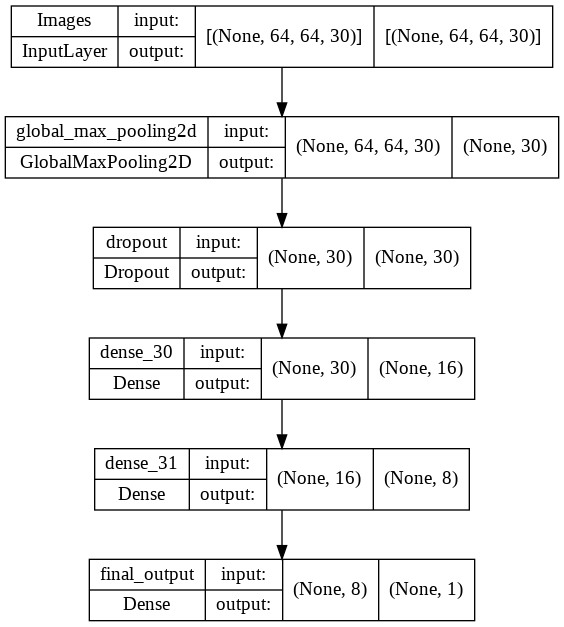

In [ ]:
model3=build_model_preTrain_MCNN()
keras.utils.plot_model(model3, show_shapes=True)

In [ ]:
folds = 5
num_val_samples = len(image3)//5
num_epochs = 20
batch_size = 30
all_train_mae_histories3, all_val_mae_histories3 = [],[]

callbacks = [
        keras.callbacks.ModelCheckpoint(
        # filepath="/content/pre_trained_MCNN.keras",
        filepath="/content/gdrive/Shareddrives/BA865/pre_trained_MCNN.keras",
        save_best_only=True,
        monitor="val_loss")]

for i in range(folds):

    print("Processing fold #:",i+1)
    
    val_image = image3[i * num_val_samples: (i + 1) * num_val_samples]

    val_targets = labels[i * num_val_samples: (i + 1) * num_val_samples]
  
    train_image = np.concatenate([image3[:i * num_val_samples], image3[(i + 1) * num_val_samples:]], axis=0)

    train_targets = np.concatenate([labels[:i * num_val_samples],labels[(i + 1) * num_val_samples:]],axis=0)
    
    model3 = build_model_preTrain_MCNN()

    history3 = model3.fit(train_image, train_targets,
                        validation_data=(val_image, val_targets),
                        epochs=num_epochs, batch_size=batch_size,callbacks=callbacks)
    
    train_mae_history3 = history3.history['mae']
    val_mae_history3 = history3.history['val_mae']

    all_train_mae_histories3.append(train_mae_history3)
    all_val_mae_histories3.append(val_mae_history3)

average_train_mae_history3 = [np.mean([x[i] for x in all_train_mae_histories3]) for i in range(num_epochs)]
average_val_mae_history3 = [np.mean([x[i] for x in all_val_mae_histories3]) for i in range(num_epochs)]

Processing fold #: 1
Epoch 1/20
54/54 [==============================] - 2s 27ms/step - loss: 30.2686 - mae: 30.2686 - val_loss: 29.5470 - val_mae: 29.5470
Epoch 2/20
54/54 [==============================] - 1s 13ms/step - loss: 26.7668 - mae: 26.7668 - val_loss: 24.1022 - val_mae: 24.1022
Epoch 3/20
54/54 [==============================] - 1s 12ms/step - loss: 19.1608 - mae: 19.1608 - val_loss: 13.8277 - val_mae: 13.8277
Epoch 4/20
54/54 [==============================] - 1s 13ms/step - loss: 8.9227 - mae: 8.9227 - val_loss: 5.7035 - val_mae: 5.7035
Epoch 5/20
54/54 [==============================] - 1s 16ms/step - loss: 6.9434 - mae: 6.9434 - val_loss: 5.5990 - val_mae: 5.5990
Epoch 6/20
54/54 [==============================] - 1s 15ms/step - loss: 6.8165 - mae: 6.8165 - val_loss: 5.5408 - val_mae: 5.5408
Epoch 7/20
54/54 [==============================] - 1s 15ms/step - loss: 6.6845 - mae: 6.6845 - val_loss: 5.5803 - val_mae: 5.5803
Epoch 8/20
54/54 [==============================] 

5.654


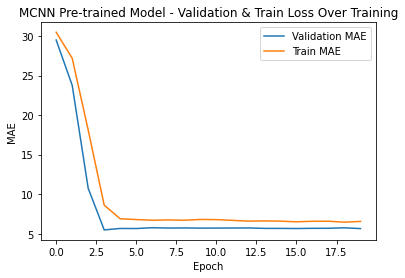

In [ ]:
avg_val_mae_MCNN = round(average_val_mae_history3[-1],3)
print(avg_val_mae_MCNN)

plt.plot(average_val_mae_history3,label='Validation MAE')
plt.plot(average_train_mae_history3,label='Train MAE')
plt.legend()
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.title('MCNN Pre-trained Model - Validation & Train Loss Over Training')
plt.show()

## CSRNet: CNN2D frond-end + Dilated CNN back-end


The CSRNet model is based on the paper called CSRNet: Dilated Convolutional Neural Networks for Understanding the Highly
Congested Scenes (https://arxiv.org/pdf/1802.10062.pdf). The author thinks the MCNN model is hard to train and inefficient due to the branch structure. Thus the proposed CSRNet deploys deepper dilated convolutional layers as the backend to capture high-level features. The pretrained parameters come from https://github.com/leeyeehoo/CSRNet-pytorch, also based on Shanghai Tech Crowd Dataset B (for Shanghai Street images).

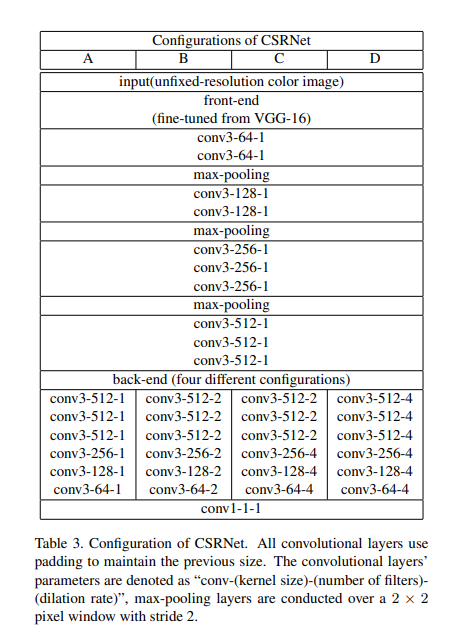

Because the output layers in the original model directly generate crowd number, we only used the layers in the front-end and the back-end, and use GlobalMaxPooling layer before the dense layers as well.

In [ ]:
import sys
sys.path.append("/content/ba865data/CSRNet")
# sys.path.append("/content/gdrive/Shareddrives/BA865/CSRNet")
from CSRNet import CSRNet
import network
import torch
import matplotlib.pyplot as plt
import PIL.Image as Image

In [ ]:
CSRNet = CSRNet().cuda()
checkpoint = torch.load('/content/ba865data/CSRNet/partBmodel_best.pth.tar')
# checkpoint = torch.load('/content/gdrive/Shareddrives/BA865/CSRNet/partBmodel_best.pth.tar')
CSRNet.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
CSRNet

CSRNet(
  (frontend): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [ ]:
from torchvision import datasets, transforms
transform = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [ ]:
def read_img_pre3():
  image_list = []
  for file in glob.glob(f"/content/ba865data/frames/*"):

    img = transform(Image.open(file).convert('RGB')).cuda()
    pre = torch.nn.Sequential(*(list(CSRNet.frontend)+list(CSRNet.backend)))
    image_list.append(np.array(pre(img.unsqueeze(0)).detach().cpu().numpy()))
    
  return np.stack(image_list)

image4 = read_img_pre3()
image4.shape

(2000, 1, 64, 32, 32)

In [ ]:
image4=np.reshape(image4,(2000,32,32,64))

In [ ]:
def build_model_preTrain_CSRNet(dropout=0.5):
  input = layers.Input(shape=(image4.shape[1],image4.shape[2],image4.shape[3]), name="Images")
  x = layers.GlobalMaxPooling2D()(input)
  x = layers.Dropout(dropout)(x)

  x = layers.Dense(32,activation="relu")(x)
  x = layers.Dense(16,activation="relu")(x)
  x = layers.Dense(8,activation="relu")(x)

  final_output=layers.Dense(1,activation="relu",name="final_output")(x)
  model=keras.Model(name="Crowd",inputs=input,outputs=final_output)
  
  model.compile(loss="mae",optimizer="Adam",metrics=['mae'])

  return model

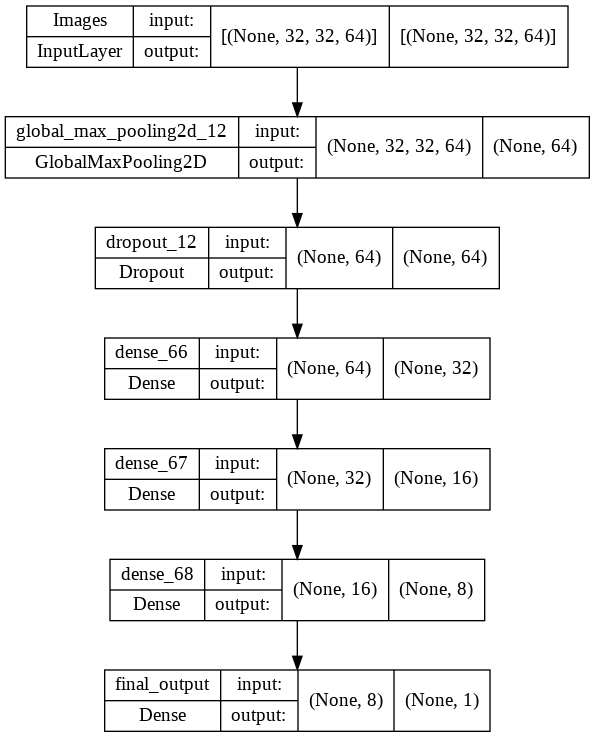

In [ ]:
model4=build_model_preTrain_CSRNet()
keras.utils.plot_model(model4, show_shapes=True)

In [ ]:
folds = 5
num_val_samples = len(image4)//5
num_epochs = 20
batch_size = 30
all_train_mae_histories4, all_val_mae_histories4 = [],[]

callbacks = [
        keras.callbacks.ModelCheckpoint(
        # filepath="/content/CSRNet.keras",
        filepath="/content/gdrive/Shareddrives/BA865/CSRNet.keras",
        save_best_only=True,
        monitor="val_loss")]

for i in range(folds):

    print("Processing fold #:",i+1)
    
    val_image = image4[i * num_val_samples: (i + 1) * num_val_samples]

    val_targets = labels[i * num_val_samples: (i + 1) * num_val_samples]
  
    train_image = np.concatenate([image4[:i * num_val_samples], image4[(i + 1) * num_val_samples:]], axis=0)

    train_targets = np.concatenate([labels[:i * num_val_samples],labels[(i + 1) * num_val_samples:]],axis=0)
    
    model4 = build_model_preTrain_CSRNet()

    history4 = model4.fit(train_image, train_targets,
                        validation_data=(val_image, val_targets),
                        epochs=num_epochs, batch_size=batch_size,callbacks=callbacks)
    
    train_mae_history4 = history4.history['mae']
    val_mae_history4 = history4.history['val_mae']

    all_train_mae_histories4.append(train_mae_history4)
    all_val_mae_histories4.append(val_mae_history4)

average_train_mae_history4 = [np.mean([x[i] for x in all_train_mae_histories4]) for i in range(num_epochs)]
average_val_mae_history4 = [np.mean([x[i] for x in all_val_mae_histories4]) for i in range(num_epochs)]


Processing fold #: 1
Epoch 1/20
54/54 [==============================] - 1s 18ms/step - loss: 30.4408 - mae: 30.4408 - val_loss: 29.5916 - val_mae: 29.5916
Epoch 2/20
54/54 [==============================] - 0s 8ms/step - loss: 24.4627 - mae: 24.4627 - val_loss: 15.9564 - val_mae: 15.9564
Epoch 3/20
54/54 [==============================] - 0s 8ms/step - loss: 8.7483 - mae: 8.7483 - val_loss: 6.3926 - val_mae: 6.3926
Epoch 4/20
54/54 [==============================] - 0s 7ms/step - loss: 7.0162 - mae: 7.0162 - val_loss: 6.4887 - val_mae: 6.4887
Epoch 5/20
54/54 [==============================] - 0s 8ms/step - loss: 7.1006 - mae: 7.1006 - val_loss: 6.3527 - val_mae: 6.3527
Epoch 6/20
54/54 [==============================] - 0s 8ms/step - loss: 6.8677 - mae: 6.8677 - val_loss: 6.2118 - val_mae: 6.2118
Epoch 7/20
54/54 [==============================] - 0s 7ms/step - loss: 6.8904 - mae: 6.8904 - val_loss: 6.2950 - val_mae: 6.2950
Epoch 8/20
54/54 [==============================] - 0s 8ms/s

6.052


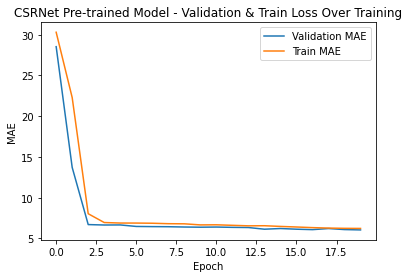

In [ ]:
avg_val_mae_CSRNet = round(average_val_mae_history4[-1],3)
print(avg_val_mae_CSRNet)

plt.plot(average_val_mae_history4,label='Validation MAE')
plt.plot(average_train_mae_history4,label='Train MAE')
plt.legend()
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.title('CSRNet Pre-trained Model - Validation & Train Loss Over Training')
plt.show()

# 4 Model Avg Validation MAE Comparison

By comparing the average validation mae, we figured that the model with MCNN as pretrained model performs the best, with the lowest MAE of 5.654.

In [ ]:
pd.DataFrame({'Model':['Self_trained','Pre_trained_Img2vec','Pre_trianed_MCNN','Pre_trained_CSRNet'],'Avg Validation MAE':[avg_val_mae_self,avg_val_mae_Img2vec,avg_val_mae_MCNN,avg_val_mae_CSRNet]})

,Model,Avg Validation MAE
0,Self_trained,6.240
1,Pre_trained_Img2vec,5.936
2,Pre_trianed_MCNN,5.654
3,Pre_trained_CSRNet,6.052


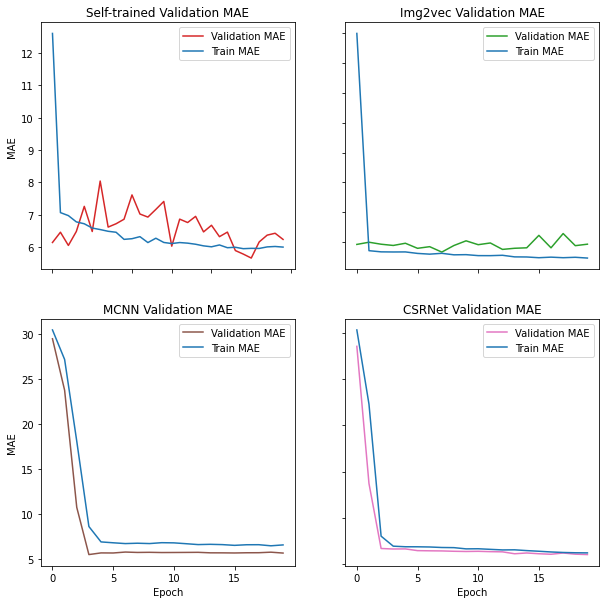

In [ ]:
fig, axs = plt.subplots(2, 2,figsize=(10,10))
axs[0, 0].plot(average_val_mae_history1,'tab:red',label='Validation MAE')
axs[0, 0].plot(average_train_mae_history1,label='Train MAE')
axs[0, 0].set_title('Self-trained Validation MAE')
axs[0, 1].plot(average_val_mae_history2, 'tab:green',label='Validation MAE')
axs[0, 1].plot(average_train_mae_history2,label='Train MAE')
axs[0, 1].set_title('Img2vec Validation MAE')
axs[1, 0].plot(average_val_mae_history3,'tab:brown',label='Validation MAE')
axs[1, 0].plot(average_train_mae_history3,label='Train MAE')
axs[1, 0].set_title('MCNN Validation MAE')
axs[1, 1].plot(average_val_mae_history4,'tab:pink',label='Validation MAE')
axs[1, 1].plot(average_train_mae_history4,label='Train MAE')
axs[1, 1].set_title('CSRNet Validation MAE')

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='MAE')
    ax.legend()


for ax in axs.flat:
    ax.label_outer()

# Performance on Test Dataset

For the test dataset, we took 34 photos around the BU campus. The locations are generally at the bus and train stops, as well as crosswalk.

In [ ]:
df1 = pd.read_csv("/content/ba865data/test_labels.csv")
df1=df1.rename({'count':'crowd_num'},axis=1)
labels_test = df1['crowd_num']
print(labels_test.describe())

count    34.000000
mean      8.176471
std       5.072030
min       2.000000
25%       5.000000
50%       6.500000
75%       9.750000
max      20.000000
Name: crowd_num, dtype: float64


In [ ]:
Xnet = CrowdCounter()
trained_model = os.path.join('/content/ba865data/MCNN/mcnn_shtechB_110.h5')
# trained_model = os.path.join('/content/gdrive/Shareddrives/BA865/MCNN/mcnn_shtechB_110.h5')
network.load_net(trained_model, net)
MCNN=net.cuda()

In [ ]:
transform = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [ ]:
image_size = (256,256)
def read_images4():
  image_list = []
  for file in glob.glob(f"/content/ba865data/test_imgs/*"):
    img = transform(Image.open(file).convert('RGB')).cuda()
    image_list.append(np.array(MCNN.DME(img.unsqueeze(0)).detach().cpu().numpy()))
    
  return np.stack(image_list)
image_test = read_images4()
image_test.shape

(34, 1, 30, 64, 64)

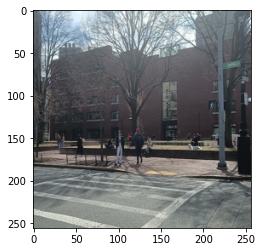

In [ ]:
plt.imshow(Image.open(glob.glob(f"/content/ba865data/test_imgs/*")[15]).resize(size=image_size));

In [ ]:
image_test=np.reshape(image_test,(34,64,64,30))

In [ ]:
test_model = keras.models.load_model("/content/gdrive/Shareddrives/BA865/pre_trained_MCNN.keras")
# test_model = keras.models.load_model("/content/pre_trained_MCNN.keras")
test_loss, test_mae = test_model.evaluate(image_test,labels_test) 
print(f"Test accuracy: {test_mae}")

2/2 [==============================] - 0s 4ms/step - loss: 23.9672 - mae: 23.9672
Test accuracy: 23.9671688079834


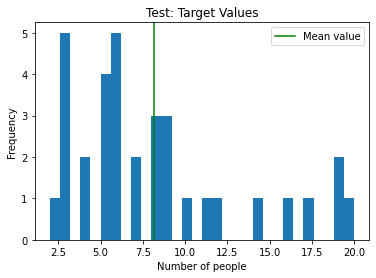

In [ ]:
plt.hist(df1['crowd_num'],bins=30) #GB: Code error... you need this col name to be 'crowd_num'
plt.axvline(df1['crowd_num'].mean(),label='Mean value',color='green')
plt.legend()
plt.xlabel('Number of people')
plt.ylabel('Frequency')
plt.title('Test: Target Values')
plt.show()

In [ ]:
summary = pd.concat([df.groupby('crowd_num').count().rename({'id':'train_count'},axis=1),df1.groupby('crowd_num').count().rename({'id':'test_count'},axis=1)],axis=1)

In [ ]:
font_color = '#525252'
hfont = {'fontname':'Calibri'}
color_blue = '#1f77b4'
color_orange = '#ff7f0e'
index = summary.index
column0 = summary['train_count']
column1 = summary['test_count']
title0 = 'Train image crowd_num'
title1 = 'Test image crowd_num' #GB: Changed this to 'Test'; you had a duplicate title in the plot.

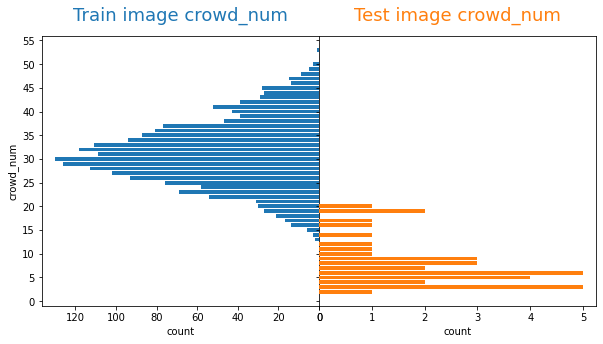

In [ ]:
fig, axes = plt.subplots(figsize=(10,5), ncols=2, sharey=True)
fig.tight_layout(pad=0)
axes[0].barh(index, column0, align='center', color=color_blue, zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15, color=color_blue, **hfont)
axes[1].barh(index, column1, align='center', color=color_orange, zorder=10)
axes[1].set_title(title1, fontsize=18, pad=15, color=color_orange, **hfont)
axes[1].set(xlabel='count')
axes[0].invert_xaxis()    
axes[0].set(yticks=[0,5,10,15,20,25,30,35,40,45,50,55], yticklabels=[0,5,10,15,20,25,30,35,40,45,50,55])
axes[0].yaxis.tick_left()
axes[0].set(ylabel='crowd_num',xlabel='count')
axes[0].tick_params(axis='y', colors='black') # tick color
plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)

# Conclusion

In conclusion, the MCNN pretrained model performed the best, with the lowest Validation MAE of 5.654.But the model does not perform well on the test dataset. It is probably because that images in test dataset have different angels and backgrounds from images in the train dataset. After carefully browsing through the images in the training set, we found that people in some of the images were so close to other people and objects, that it was difficult to distinguish people even with the naked eye.

In the future, we could try to train the model with more images of different places, to let it learn more information. Or, it may be better to use the thermograms generated by the Infrared camera for crowd counting. First, it could protect people’s privacy because the heat map does not record the gender, appearance, dress, or behavior of pedestrians. And the heat map is not limited by different backgrounds, because it does not record backgrounds that do not generate heat.



# Reference

*   Mall Dataset: http://personal.ie.cuhk.edu.hk/~ccloy/downloads_mall_dataset.html
*   Img2Vec: https://github.com/christiansafka/img2vec
*   MCNN: 
    1.   http://people.eecs.berkeley.edu/~yima/psfile/Single-Image-Crowd-Counting.pdf
	2.   https://github.com/svishwa/crowdcount-mcnn
*   CSRNet: 
    1.   https://arxiv.org/pdf/1802.10062.pdf
	2.   https://github.com/leeyeehoo/CSRNet-pytorch